In [1]:
#########################################################################
# Convolutional Neural Network - Fruit Classification
#########################################################################
import os

# Set the working directory
os.chdir(r'C:\Users\19144\OneDrive\Desktop\Data Science Infinity\Deep Learning\CNN')


#########################################################################
# Import required packages
#########################################################################
!pip install tensorflow==2.3.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from os import listdir
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #Preprocess images rather than 1./255...convert to RGB to BGR makes certain images stand out more
from tensorflow.keras.models import Model #Functional API in Keras
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



  Using cached scipy-1.4.1-cp38-cp38-win_amd64.whl (31.0 MB)
  Using cached numpy-1.18.5-cp38-cp38-win_amd64.whl (12.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\19144\\anaconda4\\envs\\dsi-deep-learning\\Lib\\site-packages\\~cipy\\.libs\\libansari.R6EA3HQP5KZ6TAXU4Y4ZVTRPT7UVA53Z.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [2]:
#Set up flow for training and validation daata

#data flow parameters

training_data_dir = 'data/training'
validation_data_dir = 'data/validation'
batch_size = 32
img_width = 224 #Based on VGG model
img_height = 224 #Based on VGG model
num_channels = 3
num_classes = 6

#image generations

training_generator = ImageDataGenerator(preprocessing_function = preprocess_input, #Based on VGG Model
                                        rotation_range=20, #Between -20 and 20 degree rotation will be randomly selected
                                        width_shift_range = 0.2, #Shift up to 20% of width
                                        height_shift_range = 0.2, #Shift up to 20% of height
                                        zoom_range = 0.1,
                                        horizontal_flip = True,
                                        brightness_range = (0.5,1.5),
                                        fill_mode = 'nearest') #Nearest pixel will be used to fill in any new pixels that are required
#Subtle changes are good to start with here

validation_generator = ImageDataGenerator(preprocessing_function = preprocess_input) #Based on VGG model

#image flows 

training_set = training_generator.flow_from_directory(directory=training_data_dir,
                                                      target_size=(img_width, img_height),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

validation_set = validation_generator.flow_from_directory(directory = validation_data_dir, #training data
                                                        target_size = (img_width, img_height),#Size of images
                                                        batch_size = batch_size,#Amount of images passed for each mini-batch
                                                        class_mode = "categorical")#What type of problem is being solved - multi-class classification problem her


Found 360 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [3]:
#########################################################################
# Network Architecture
#########################################################################

# network architecture

vgg = VGG16(input_shape = (img_width, img_height, num_channels), include_top = False) #This can be a massive file, so this is a shortened model
#freeze all layers (they won't be updated during training)
for layer in vgg.layers:
        layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
#Listed as non-trainable parameters as they have been frozen - there's no additional learning 

In [5]:
flatten = Flatten()(vgg.output)

dense1 = Dense(128, activation = 'relu')(flatten) #flatten will be input for dense1 layer
dense2 = Dense(128, activation = 'relu')(dense1) #ditto for dense1

output = Dense(num_classes, activation = 'softmax')(dense2)

model = Model(inputs = vgg.inputs, outputs = output)


In [6]:
# compile network
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])      

# view network architecture
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [7]:
#Notice that there are 3.228 million parameters added here...figuring out how to use those frozen parameters learned from image net data set to predict classes of fruit

In [8]:
#########################################################################
# Train Our Network!
#########################################################################

# training parameters

num_epochs = 10 #We may need less epochs here since we have layers that have already learned
model_filename = "models/fruits_cnn_vgg.h5" #h5 is file format keras will use to save architecture and values of network parameters


# callbacks
save_best_model = ModelCheckpoint(filepath = model_filename,
                                 monitor = 'val_accuracy',
                                 mode = 'max',
                                 verbose = 1,
                                 save_best_only = True)


# train the network

history = model.fit(x=training_set, #We will pass batches of training data in
                    validation_data = validation_set,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    callbacks = [save_best_model])


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 9.4136 - accuracy: 0.4472 
Epoch 00001: val_accuracy improved from -inf to 0.82222, saving model to models\fruits_cnn_vgg.h5
12/12 [==============================] - 58s 5s/step - loss: 9.4136 - accuracy: 0.4472 - val_loss: 1.0214 - val_accuracy: 0.8222
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.4101 - accuracy: 0.8333
Epoch 00002: val_accuracy improved from 0.82222 to 0.96111, saving model to models\fruits_cnn_vgg.h5
12/12 [==============================] - 54s 4s/step - loss: 1.4101 - accuracy: 0.8333 - val_loss: 0.2376 - val_accuracy: 0.9611
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.9204 - accuracy: 0.8778
Epoch 00003: val_accuracy did not improve from 0.96111
12/12 [==============================] - 59s 5s/step - loss: 0.9204 - accuracy: 0.8778 - val_loss: 0.5863 - val_accuracy: 0.9278
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 0.5821 -

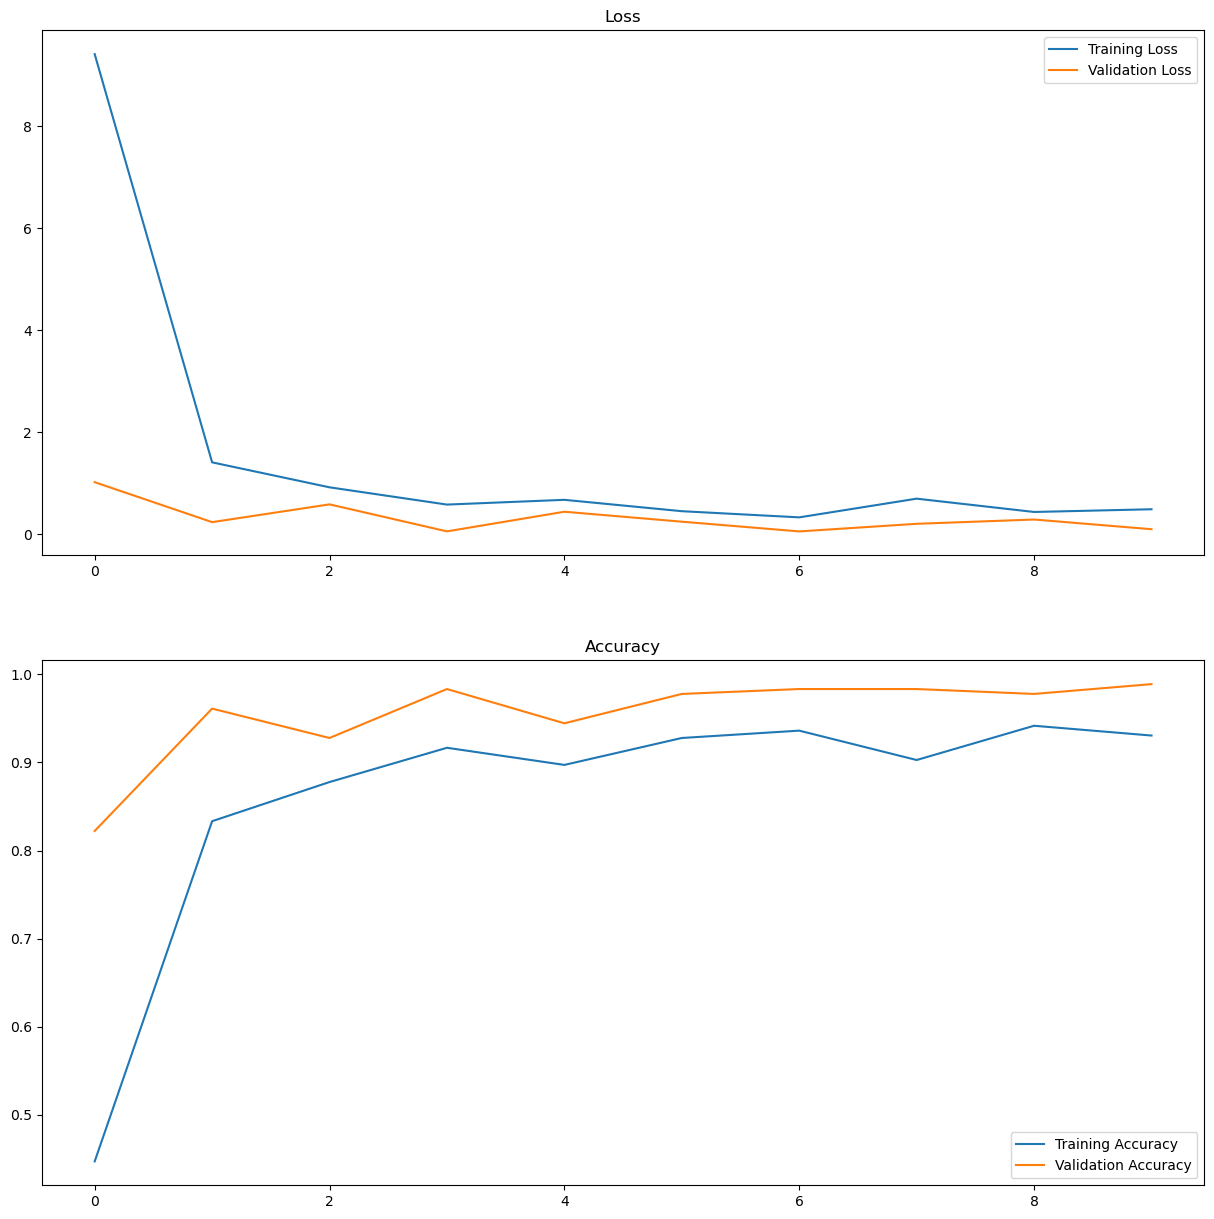

0.9888888597488403

In [9]:
#########################################################################
# Visualise Training & Validation Performance
#########################################################################

# plot validation results
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
plt.show()

# get best epoch performance for validation accuracy
max(history.history['val_accuracy'])


In [10]:
#98.8% accuracy
#Augmentation really worked well here

In [12]:
#########################################################################
# Make Predictions On New Data (Test Set)
#########################################################################

# parameters for prediction

model_filename = 'models/fruits_cnn_vgg.h5'
#Need these so that network was scanned through images in this size...we need to make sure we pass in images in the same size as we did before
img_height = 224
img_width = 224
labels_list = ['apple', 'avocado', 'banana', 'kiwi', 'lemon', 'orange'] #Written in alphabetical order in the same way they are in the directory

model = load_model(model_filename) #This ensures that you only load the architecture
# predict class probabilities
#class_probs = model.predict(image)

# print class probabilities
#print("Shape of class_probs:", class_probs.shape)
#print("Class probabilities:", class_probs)

# find the predicted class index
#predicted_class = np.argmax(class_probs)
#print("Predicted class index:", predicted_class)

# find the predicted label
#predicted_label = labels_list[predicted_class]
#print("Predicted label:", predicted_label)

# image pre-processing function

def preprocess_image(filepath):
    image = load_img(filepath, target_size = (img_width, img_height))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image = preprocess_input(image)
    return image

# image prediction function

def make_prediction(image):
    class_probs = model.predict(image)
    predicted_class = np.argmax(class_probs)
    predicted_label = labels_list[predicted_class]
    predicted_prob = class_probs[0][predicted_class]
    
    return predicted_label,predicted_prob

#loop through test data
source_dir = "data/test/"
folder_names = ['apple', 'avocado', 'banana', 'kiwi', 'lemon', 'orange']
actual_labels = []
predicted_labels = []
predicted_probabilities = []
filenames = []

for folder in folder_names:
    images = listdir(source_dir + '/' + folder)
    
    for image in images:
        
        processed_image = preprocess_image(source_dir + '/' + folder + '/' + image)
        predicted_label, predicted_probability = make_prediction(processed_image)
        
        actual_labels.append(folder)
        predicted_labels.append(predicted_label)
        predicted_probabilities.append(predicted_probability)
        filenames.append(image)
# create dataframe to analyse
predictions_df = pd.DataFrame({"actual_label":actual_labels,
                              "predicted_label":predicted_labels,
                              "predicted_probability":predicted_probabilities,
                              "filename":filenames})

predictions_df["correct"] = np.where(predictions_df["actual_label"] == predictions_df["predicted_label"], 1, 0) #1 for correct, 0 for not correct

predictions_df

,actual_label,predicted_label,predicted_probability,filename,correct
0,apple,apple,1.000000,apple_0004.jpg,1
1,apple,apple,1.000000,apple_0014.jpg,1
2,apple,apple,1.000000,apple_0024.jpg,1
3,apple,apple,1.000000,apple_0034.jpg,1
4,apple,apple,1.000000,apple_0044.jpg,1
5,apple,apple,1.000000,apple_0054.jpg,1
6,apple,apple,1.000000,apple_0064.jpg,1
7,apple,apple,1.000000,apple_0074.jpg,1
8,apple,apple,1.000000,apple_0084.jpg,1
9,apple,apple,1.000000,apple_0094.jpg,1


In [13]:
# overall test set accuracy
test_set_accuracy = predictions_df["correct"].sum() / len(predictions_df)
print(test_set_accuracy)
#98.3% accurate - This is pretty good
#This is better than 75% basic, 85% dropout...now 93% augmentation

0.9833333333333333


In [14]:
# confusion matrix raw numbers
confusion_matrix = pd.crosstab(predictions_df["predicted_label"], predictions_df["actual_label"])
confusion_matrix

actual_label,apple,avocado,banana,kiwi,lemon,orange
predicted_label,,,,,,
apple,10,0,0,0,0,0
avocado,0,10,0,0,0,0
banana,0,0,10,0,0,0
kiwi,0,0,0,10,0,0
lemon,0,0,0,0,9,0
orange,0,0,0,0,1,10


In [15]:
#Actual scores are along the top
#Predicted scores are along the left hand side
#For apples, 9/10 were right, for avacados 10/10, for bananas 9/10, for lemons 10/10


In [16]:
#Confusion matrix percentages
confusion_matrix = pd.crosstab(predictions_df["predicted_label"], predictions_df["actual_label"], normalize = 'columns')
confusion_matrix


actual_label,apple,avocado,banana,kiwi,lemon,orange
predicted_label,,,,,,
apple,1.0,0.0,0.0,0.0,0.0,0.0
avocado,0.0,1.0,0.0,0.0,0.0,0.0
banana,0.0,0.0,1.0,0.0,0.0,0.0
kiwi,0.0,0.0,0.0,1.0,0.0,0.0
lemon,0.0,0.0,0.0,0.0,0.9,0.0
orange,0.0,0.0,0.0,0.0,0.1,1.0
